## Unsupervised Learning Part 1


#### Table of Contents

- [Preliminaries](#Preliminaries)
- [KMeans](#KMeans)
- [Agglomerative Clustering](#Agglomerative-Clustering)

**************
# Preliminaries
[TOP](#Unsupervised-Learning-Part-1)

Remember, the clustering algorithms we use are based on distances.
Therefore, we will need to standardize our variables!
`metrics.py`, here we come!

In [ ]:
%run metrics.py

In [2]:
import pandas as pd
import numpy as np

# algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering

# Plotting
import matplotlib.pyplot as plt

We are going to cluster state-level new COVID cases over time. 
We can actually grab this data straight from GitHub using the following code.
[Here is a link to the Repo](https://github.com/CSSEGISandData/COVID-19) if you are curious.

It is always good practice to immediately save your data when grabbing from an online source.
The reason why is to not overload their servers, which can get you banned.

In [3]:
# pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').to_csv('COVID.csv')

Now that we have the data, comment it out with `Ctrl /`, so we aren't spamming the website everytime we run our notebook.
Loading in the data:

In [4]:
covid = pd.read_csv('COVID.csv')

Let's take a look at the data.

In [5]:
covid.columns = covid.columns.str.lower()
covid.head()

,unnamed: 0,uid,iso2,iso3,code3,fips,admin2,province_state,country_region,lat,...,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21
0,0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,...,6543,6562,6570,6577,6580,6589,6595,6606,6617,6619
1,1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,...,20423,20453,20473,20487,20492,20505,20523,20519,20526,20541
2,2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,...,2221,2224,2226,2226,2227,2227,2227,2228,2231,2232
3,3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,...,2535,2535,2536,2536,2537,2542,2543,2544,2545,2546
4,4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,...,6415,6420,6424,6426,6443,6444,6446,6455,6458,6459


Looks like we have som cleaning to do.
I am going to save us some time doing all the necessary cleaning without exploration.

Dealing with non-states and cruise liners Grand Princess and Diamond Princess

In [6]:
covid = covid.rename(columns = {'province_state': 'state'})

We have more than just states and DC!

In [7]:
covid['state'].unique()
covid['code3'].unique()

array([840,  16, 316, 580, 630, 850], dtype=int64)

Trimming.

In [8]:
keep = (~ covid['state'].str.contains('Prince')) & (covid['code3'] == 840)
covid = covid[keep]

In [9]:
covid['state'].unique()
covid['state'].nunique()

51

We are going to aggregate our county-level data to the state level. 
That means we will need to use `.groupby()`. 
Remember that this function makes the group variable the index.

We are going to do the following:

1. Select an approximate year of data, which we will trim later
2. aggergate by states
3. transpose to make the states variables
4. take the difference to convert cumulative cases to new cases
5. remove any `NaN`s

all in one line.

In [10]:
covid = covid.loc[:, '3/1/20':'3/8/21'].groupby(covid['state']).sum().transpose().diff().dropna()

Now we can convert our index to a `datetime`.

In [11]:
covid.index = pd.to_datetime(covid.index)

Trimming to be one year based upon the week number. 
The number of the week starts on Mondays.

In [12]:
covid.index.isocalendar()
covid = covid.loc[:'2021-03-07']

Now we are going to aggregate to weekly new cases:

In [13]:
covid.join(covid.index.isocalendar()[['year','week']]).groupby(['year', 'week']).sum().reset_index()
covid = covid.join(covid.index.isocalendar()[['year','week']]).groupby(['year', 'week']).sum().reset_index()

For plotting purposes, it will be useful to get our dates back. 
Let's do some string math!

In [14]:
covid['year'].astype(str) + '-' + covid['week'].astype('str') + '-1'
covid.index = pd.to_datetime(covid['year'].astype(str) + '-' + covid['week'].astype('str') + '-1',
                            format = '%Y-%W-%w')

Removing columns that we will confidently never use again.

In [15]:
covid.drop(columns = ['year', 'week'], inplace = True)

Remembering to standardize!

In [16]:
covid = covid.apply(stdz)

And now we can take a look at our beauty.

In [17]:
df_plot = covid.copy()
df_plot.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-03-09,-1.234453,-0.874169,-0.928008,-1.157045,-0.829769,-0.891636,-0.978747,-1.053764,-1.470838,-1.263827,...,-0.872082,-1.019447,-1.213153,-1.036495,-0.830605,-1.108783,-1.134917,-0.830081,-0.916381,-0.749249
2020-03-16,-1.230787,-0.873388,-0.927711,-1.156479,-0.827384,-0.878635,-0.974384,-1.049972,-1.470838,-1.261071,...,-0.868827,-1.017654,-1.212151,-1.034150,-0.822367,-1.105471,-1.069196,-0.830081,-0.914193,-0.747799
2020-03-23,-1.214556,-0.854648,-0.919853,-1.126461,-0.815150,-0.842774,-0.923661,-1.022159,-1.278865,-1.233031,...,-0.866792,-0.994754,-1.199602,-1.015535,-0.704279,-1.090619,-0.907024,-0.824806,-0.888802,-0.731847
2020-03-30,-1.142823,-0.807798,-0.882532,-1.107770,-0.779257,-0.706916,-0.675865,-0.942513,-1.019136,-1.152491,...,-0.844005,-0.928123,-1.162145,-0.954855,-0.330791,-1.041748,-0.716255,-0.798102,-0.855207,-0.705742
2020-04-06,-1.100281,-0.814825,-0.847829,-1.079451,-0.718517,-0.606268,-0.309352,-0.775004,-0.228657,-0.985005,...,-0.811046,-0.887703,-1.107223,-0.907513,-0.072646,-0.933368,-0.557813,-0.760518,-0.826065,-0.668762


Let's take a look at our data!

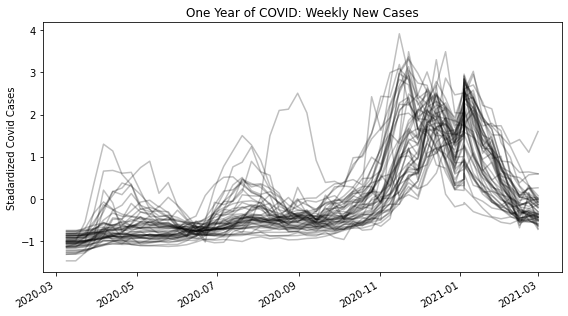

In [18]:
df_plot.plot(legend = False,
         color = 'black',
         alpha = 0.25,
         figsize = (8, 4.5))
plt.ylabel('Stadardized Covid Cases')
plt.title('One Year of COVID: Weekly New Cases')
plt.tight_layout()
plt.savefig('state covid', dpi = 300)

Finally, let's transpose our data again for analysis such that each row is an observation.

In [19]:
df = df_plot.transpose()
df.head()

,2020-03-09,2020-03-16,2020-03-23,2020-03-30,2020-04-06,2020-04-13,2020-04-20,2020-04-27,2020-05-04,2020-05-11,...,2021-01-04,2021-01-04,2021-01-11,2021-01-18,2021-01-25,2021-02-01,2021-02-08,2021-02-15,2021-02-22,2021-03-01
Alabama,-1.234453,-1.230787,-1.214556,-1.142823,-1.100281,-1.003808,-1.062844,-1.038496,-1.037842,-0.971999,...,2.208986,2.688078,1.474902,1.196610,1.183128,0.438965,-0.120761,-0.460576,-0.395519,-0.374837
Alaska,-0.874169,-0.873388,-0.854648,-0.807798,-0.814825,-0.804674,-0.836689,-0.856990,-0.853086,-0.864018,...,0.935811,0.781205,0.469651,0.201043,-0.082400,-0.162827,0.023793,-0.097236,-0.179224,-0.062879
Arizona,-0.928008,-0.927711,-0.919853,-0.882532,-0.847829,-0.852413,-0.845389,-0.832889,-0.802829,-0.780626,...,2.765107,2.771953,2.365641,1.970162,1.204563,0.395213,0.061878,-0.291457,-0.403482,-0.352469
Arkansas,-1.157045,-1.156479,-1.126461,-1.107770,-1.079451,-1.073410,-1.062460,-0.926718,-1.074732,-1.048489,...,2.354129,2.921075,1.878371,1.280652,0.957815,1.008034,0.030841,-0.687706,0.145816,-0.703376
California,-0.829769,-0.827384,-0.815150,-0.779257,-0.718517,-0.735730,-0.722517,-0.681192,-0.690893,-0.672873,...,2.512996,2.738315,2.477421,1.286200,0.842635,0.315722,-0.000626,-0.267979,-0.401777,-0.435199


******************
# KMeans
[TOP](#Unsupervised-Learning-Part-1)

We are going to fit a few `KMeans()` algorithms and then plot the colors on our figure.

In [20]:
clst_km = KMeans(n_clusters = 4, random_state = 490).fit(df)
labels = clst_km.labels_

Obtaining the default colors from matplotlib

In [21]:
color_map = pd.DataFrame(plt.rcParams['axes.prop_cycle'])

Grabbing the average trajectory of each cluster.

In [22]:
df_clst_avg = df.copy()
df_clst_avg['Cluster'] = labels
df_clst_avg = df_clst_avg.groupby('Cluster').mean().transpose()

The corresponding color for individual state series.

In [23]:
colors = color_map.iloc[clst_km.labels_].to_numpy().flatten()

And the plot!

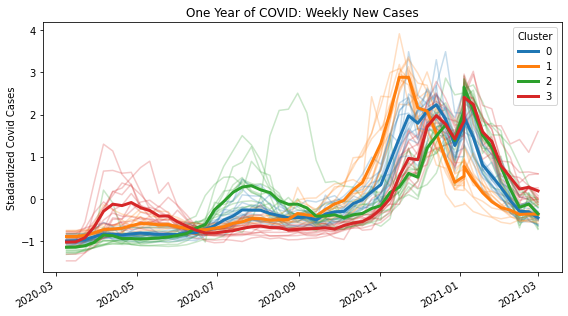

In [24]:
_, ax = plt.subplots(figsize = (8, 4.5))

df_plot.plot(legend = False,
         color = colors,
         alpha = 0.25,
         figsize = (8, 4.5),
          ax = ax)

df_clst_avg.plot(ax = ax, 
                linewidth = 3)

plt.ylabel('Stadardized Covid Cases')
plt.title('One Year of COVID: Weekly New Cases')
plt.tight_layout()

Because we have so few observations, we can visually inspect to see how good of a grouping we have found.
To help ourselves out, let's define some functions!

In [25]:
def clust_avg(data, labels):
    df_clst_avg = data.copy()
    df_clst_avg['Cluster'] = labels
    df_clst_avg = df_clst_avg.groupby('Cluster').mean().transpose()
    return df_clst_avg
    
def clust_plot(data_plot, df_clst_avg, labels, cmap):
    colors = color_map.iloc[labels].to_numpy().flatten()
    
    _, ax = plt.subplots(figsize = (8, 4.5))

    data_plot.plot(legend = False,
             color = colors,
             alpha = 0.25,
              ax = ax)

    df_clst_avg.plot(ax = ax, 
                    linewidth = 3)
    
    plt.ylabel('Stadardized Covid Cases')
    plt.title('One Year of COVID: Weekly New Cases')
    plt.tight_layout()
    
def plot_kmeans(n_clust, data, data_plot, cmap):
    clst_km = KMeans(n_clusters = n_clust, random_state = 490).fit(data)
    labels = clst_km.labels_
    
    clst_avg = clust_avg(data, labels)
    
    clust_plot(data_plot, clst_avg, labels, cmap)
    
    return clst_km

Checkout how easy this is!

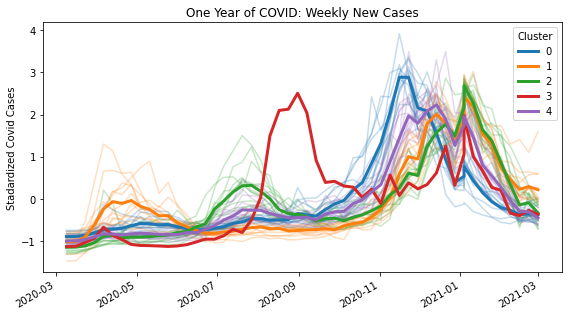

In [26]:
fit = plot_kmeans(5, df, df_plot, color_map)

What is that isolated state with the peak around September 2020?

In [27]:
pd.DataFrame({'Cluster': fit.labels_},
         index = df.index).sort_values('Cluster')

,Cluster
Wyoming,0
Wisconsin,0
Minnesota,0
Michigan,0
Iowa,0
North Dakota,0
Montana,0
South Dakota,0
Illinois,0
Nebraska,0


****************
# Agglomerative Clustering
[TOP](#Unsupervised-Learning-Part-1)

We are going to showcase how to fit a agglomerative model and plot its dendrogram. 
Scikit-learn provides a function for plotting dendrograms, so we are simply going to use it.

From [Scikit-learn's website](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py):

In [28]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

We are going to fit the entire "tree", which means setting `n_clusters = None` and `distance_threshold = 0`.
We also need the distances for Scikit-learn's functions, so we will set `compute_distances = True`.

In [29]:
clst_agg = AgglomerativeClustering(n_clusters = None,
                                  distance_threshold = 0, # compute the full tree
                                  compute_full_tree = True, #b/c small data
                                  linkage = 'ward', # default
                                  compute_distances = True) 
clst_agg.fit(df)

AgglomerativeClustering(compute_distances=True, compute_full_tree=True,
                        distance_threshold=0, n_clusters=None)

Now some easy-peasy plotting!

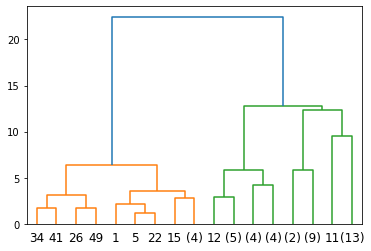

In [30]:
plot_dendrogram(clst_agg,
               truncate_mode = 'level',
               p = 3) # Mess around 
# I would say ~ 4 or 5

## Alternative Distances

`AgglomerativeClustering()` has the additional argument `affinity`. 
This allows you to produce different dissimilarity functions (i.e. distances).
Alternatively, you can manually specify your own custom distances.
We are going to specifiy a correlation distance using pandas `.corr()` method on data frames.
This produces correlations over features, so we will need to transpose our data.
*Note:* `KMeans()` *does not have this feature*.

**Do we need to standardize our data with a correlation distance?**

Note that as the correlation increases, the likeness increases. Therefore, we need to subtract the correlation from 1.

In [31]:
df
df.transpose()
corr_dist = 1 - df.transpose().corr()

Here is the alternative way to use agglomerative clustering.

In [32]:
clst_agg_corr = AgglomerativeClustering(n_clusters = None,
                                  distance_threshold = 0, # compute the full tree
                                  compute_full_tree = True, #b/c small data
                                  linkage = 'average',
                                        affinity = 'precomputed',
                                  compute_distances = True) 
clst_agg_corr.fit(corr_dist)

AgglomerativeClustering(affinity='precomputed', compute_distances=True,
                        compute_full_tree=True, distance_threshold=0,
                        linkage='average', n_clusters=None)

Ah, time for another dendrogram.

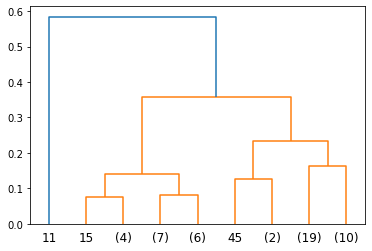

In [33]:
plot_dendrogram(clst_agg_corr,
               truncate_mode = 'level',
               p = 3) # maybe 3-4

Let's produce one more figure for good times sake.

In [34]:
clst_agg_corr = AgglomerativeClustering(n_clusters = 4,
                                        compute_full_tree = True, #b/c small data
                                  linkage = 'average',
                                        affinity = 'precomputed',
                                  compute_distances = True) 
clst_agg_corr.fit(corr_dist)
labels = clst_agg_corr.labels_

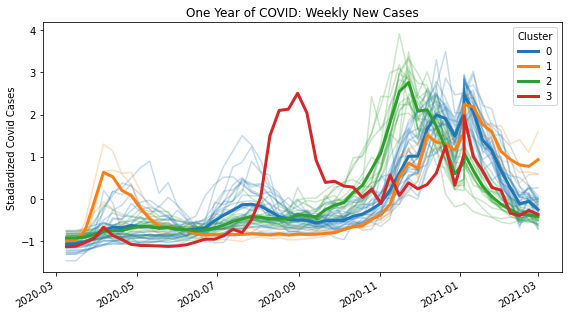

In [35]:
df_avg = clust_avg(df, labels)

clust_plot(df_plot, df_avg, labels, color_map)

In [36]:
df.to_csv('state covid.csv')